# DailyBeer Sales and Buy

In [38]:
import sqlite3
conn_sales = sqlite3.connect("Sales.db")

## 1. Monthly Sales and Buy

### DF_Sales, DF_Bsales, DF_CJsales, DF_Bbuy, DF_CJbuy

In [39]:
from pandas import Series, DataFrame
import pandas as pd


sql_cmd_Sales = """
        select year, month, sum(amount) as Sales
        from  sales
        group by month
        order by year, month
"""
DF_Sales = pd.read_sql_query(sql_cmd_Sales, conn_sales)
DF_Sales = DF_Sales.set_index(['year', 'month'])



sql_cmd_Bsales = """
                    select year, month, sum(amount) as Bsales
                    from sales
                    where cat1 = 2 or cat1 = 6
                    group by year, month
"""
DF_Bsales = pd.read_sql_query(sql_cmd_Bsales, conn_sales)
DF_Bsales = DF_Bsales.set_index(['year', 'month'])



sql_cmd_CJsales = """
                    select year, month, sum(amount) as CJsales
                    from sales
                    where cat1 = 3
                    group by year, month
"""
DF_CJsales = pd.read_sql_query(sql_cmd_CJsales, conn_sales)
DF_CJsales = DF_CJsales.set_index(['year', 'month'])


sql_cmd_Bbuy = """
        select year, month, sum(amount) as Bbuy
        from beer
        group by month
        order by year, month
"""
DF_Bbuy = pd.read_sql_query(sql_cmd_Bbuy, conn_sales)
DF_Bbuy = DF_Bbuy.set_index(['year', 'month'])



sql_cmd_CJbuy = """
        select year, month, sum(total) as CJbuy
        from OrderAll
        group by month
        order by year, month
"""
DF_CJbuy = pd.read_sql_query(sql_cmd_CJbuy, conn_sales)
DF_CJbuy = DF_CJbuy.set_index(['year', 'month'])


## Sales CJ:B -- pd.concat( [DF_Bsales, DF_CJsales] , axis = 1)

In [40]:
DF_CJB_Sales = pd.concat( [DF_Bsales, DF_CJsales], axis =1)
DF_CJB_Sales['Sales'] = DF_CJB_Sales['Bsales'] + DF_CJB_Sales['CJsales']
DF_CJB_Sales['CJsales_rate'] = DF_CJB_Sales['CJsales'] / DF_CJB_Sales['Sales'] * 100
DF_CJB_Sales['Bsales_rate'] = DF_CJB_Sales['Bsales'] / DF_CJB_Sales['Sales'] * 100
DF_CJB_Sales

Bsales   CJsales     Sales  CJsales_rate  Bsales_rate
year month                                                         
2017 7      34292379  16890571  51182950     33.000386    66.999614
     8      32386200  18277000  50663200     36.075495    63.924505
     9      26439450  13706500  40145950     34.141676    65.858324
     10     21552100  11784200  33336300     35.349454    64.650546
     11     17135500   9869750  27005250     36.547523    63.452477
     12     17748159  10456191  28204350     37.072973    62.927027
2018 1      18861800  12744000  31605800     40.321713    59.678287
     2      16097564   9275636  25373200     36.556824    63.443176

### Sales(total) Graph

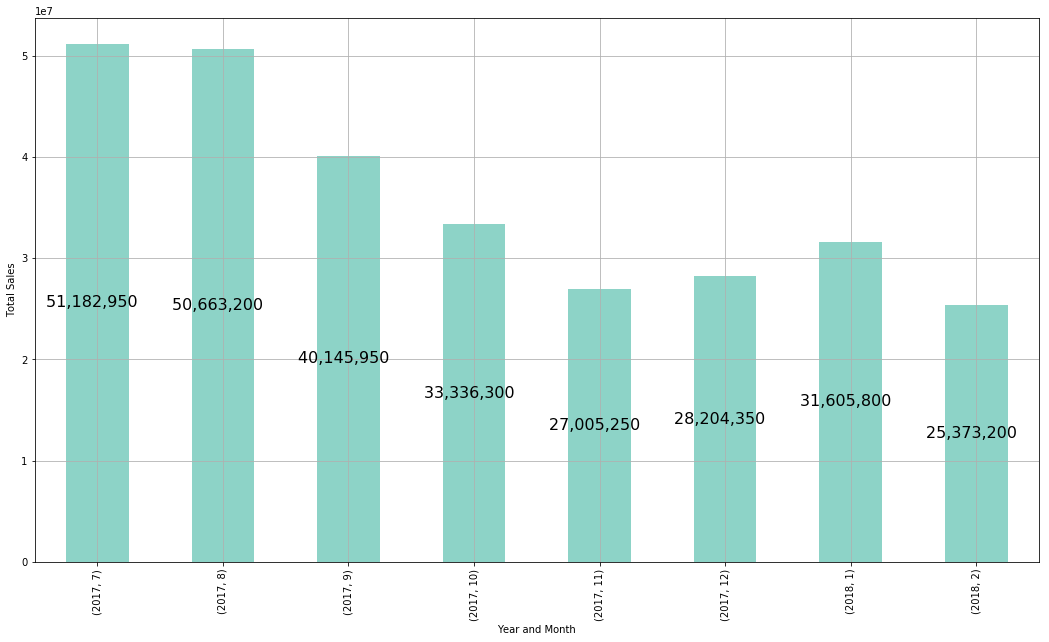

In [63]:

fig = plt.figure()
ax = DF_CJB_Sales['Sales'].plot.bar(stacked=True, figsize=(18,10), grid=True, colormap='Set3')


ax.set_xlabel('Year and Month')
ax.set_ylabel('Total Sales')


labels = []

for i in DF_CJB_Sales.index:
    value_str = "{:<12,}".format(int(DF_CJB_Sales.loc[i]['Sales'])) 
    labels.append(value_str)


# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=16)

fig  = ax.get_figure()
fig.savefig('Sales-Total.png')




### Sales(CJ:B) Graph

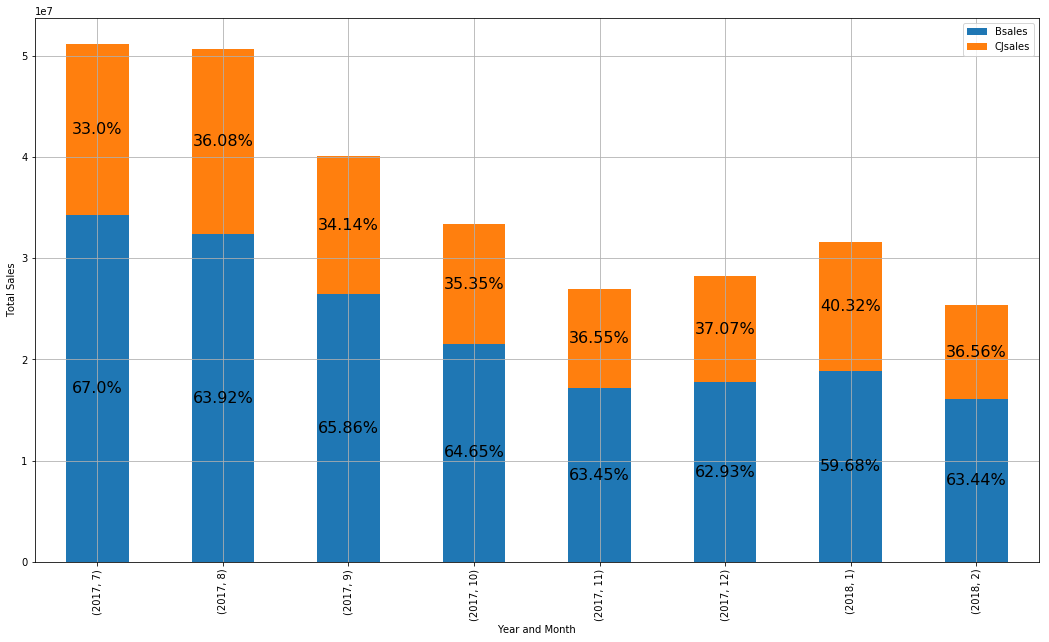

In [42]:
import matplotlib.pyplot as plt


fig = plt.figure()
DF_CJB_Sales_Graph = DF_CJB_Sales[['Bsales', 'CJsales']]
ax = DF_CJB_Sales_Graph.plot.bar(stacked=True, figsize=(18,10), grid=True)


ax.set_xlabel('Year and Month')
ax.set_ylabel('Total Sales')

pct_str=""

labels = []
for j in DF_CJB_Sales_Graph.columns:
    pct_str=""
    for i in DF_CJB_Sales_Graph.index:
#        value_str = "{:<12,}".format(int(DF_CJB_Sales_Graph.loc[i][j])) 
        
        if j == 'Bsales':
            pct_str = "{0:.4}%".format(DF_CJB_Sales.loc[i]['Bsales_rate'])
        elif j == 'CJsales':
            pct_str = "{0:.4}%".format(DF_CJB_Sales.loc[i]['CJsales_rate'])

        if pct_str != "":
            value_str = value_str + "::" + pct_str
#       label = DF_RCB[i][j] 
#        labels.append(value_str)
        labels.append(pct_str)


# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=16)

fig  = ax.get_figure()
fig.savefig('Sales-CJ:B.png')






## pd.concat( [DF_Sales, DF_CJbuy,  DF_Bbuy] )  and Calcuate the CJB Rate 

In [43]:

DF_M = pd.concat([DF_Sales, DF_CJbuy, DF_Bbuy], axis=1)
DF_M.loc[DF_M['Bbuy'].isnull(), 'Bbuy'] = 0

DF_M['R'] = DF_M['Sales'] - ( DF_M['CJbuy'] + DF_M['Bbuy'])
DF_M['CJ+Beer_Rate'] = ((DF_M['CJbuy'] + DF_M['Bbuy']) / DF_M['Sales'] * 100)
DF_M['CJ_Rate'] = (DF_M['CJbuy'] / DF_M['Sales']) * 100
DF_M['Beer_Rate'] = (DF_M['Bbuy'] / DF_M['Sales']) * 100
DF_M['R_Rate'] = (DF_M['R']/DF_M['Sales']) * 100
DF_M

Sales    CJbuy       Bbuy           R  CJ+Beer_Rate    CJ_Rate  \
year month                                                                      
2017 7      51182950  8474601        0.0  42708349.0     16.557469  16.557469   
     8      50663200  7594394        0.0  43068806.0     14.989961  14.989961   
     9      40145950  6673702  8510300.0  24961948.0     37.822002  16.623600   
     10     33336300  4974996  7362700.0  20998604.0     37.009794  14.923660   
     11     27005250  4325622  3511400.0  19168228.0     29.020365  16.017708   
     12     28204350  4400016  6820800.0  16983534.0     39.783991  15.600487   
2018 1      31605800  2959125  5753900.0  22892775.0     27.567804   9.362601   
     2      25373200  3821956  5687000.0  15864244.0     37.476377  15.062964   

            Beer_Rate     R_Rate  
year month                        
2017 7       0.000000  83.442531  
     8       0.000000  85.010039  
     9      21.198402  62.177998  
     10     22.086134  62.990206  
     11     13.002657  70.979635  
     12     24.183504  60.216009  
2018 1      18.205203  72.432196  
     2      22.413413  62.523623

##  Buy(CJB):Sales Graph

### CJ:B:Sales

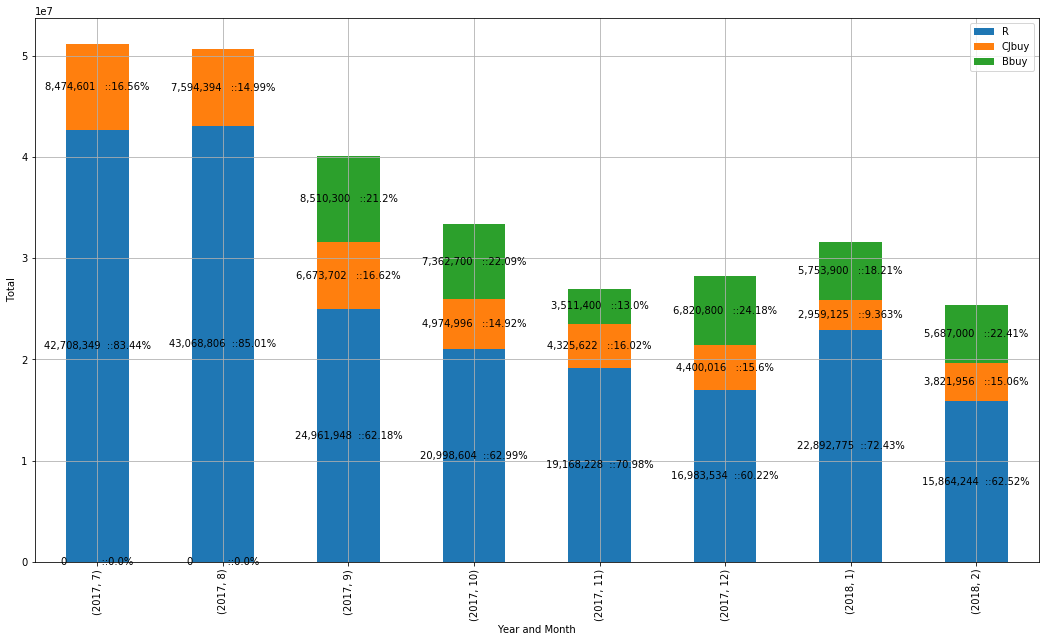

In [44]:

fig = plt.figure()
DF_RCB = DF_M[['R', 'CJbuy', 'Bbuy']]
ax = DF_RCB.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_RCB.columns:
    pct_str=""
    for i in DF_RCB.index:
        value_str = "{:<12,}".format(int(DF_RCB.loc[i][j])) 
        
        if j == 'CJbuy':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['CJ_Rate'])
        elif j == 'Bbuy':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['Beer_Rate'])
        elif j == 'R':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['R_Rate'])

        if pct_str != "":
            value_str = value_str + "::" + pct_str
#       label = DF_RCB[i][j] 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')

fig  = ax.get_figure()
fig.savefig('Sales-CJBbuy.png')


# 2. Beer Sell:Buy Rate

In [45]:

DF_Bmerge = pd.concat([DF_Bsales, DF_Bbuy], axis = 1) 
DF_Bmerge.loc[DF_Bmerge['Bbuy'].isnull(), 'Bbuy'] = 0

DF_Bmerge['R'] = DF_Bmerge['Bsales'] - DF_Bmerge['Bbuy']
DF_Bmerge['brate'] = DF_Bmerge['Bbuy'] / DF_Bmerge['Bsales'] * 100
DF_Bmerge['prate'] = 100- (DF_Bmerge['Bbuy'] / DF_Bmerge['Bsales'] * 100)

DF_Bmerge



Bsales       Bbuy           R      brate       prate
year month                                                        
2017 7      34292379        0.0  34292379.0   0.000000  100.000000
     8      32386200        0.0  32386200.0   0.000000  100.000000
     9      26439450  8510300.0  17929150.0  32.187886   67.812114
     10     21552100  7362700.0  14189400.0  34.162332   65.837668
     11     17135500  3511400.0  13624100.0  20.491961   79.508039
     12     17748159  6820800.0  10927359.0  38.431028   61.568972
2018 1      18861800  5753900.0  13107900.0  30.505572   69.494428
     2      16097564  5687000.0  10410564.0  35.328327   64.671673

### Beer Sell:Buy Graph 

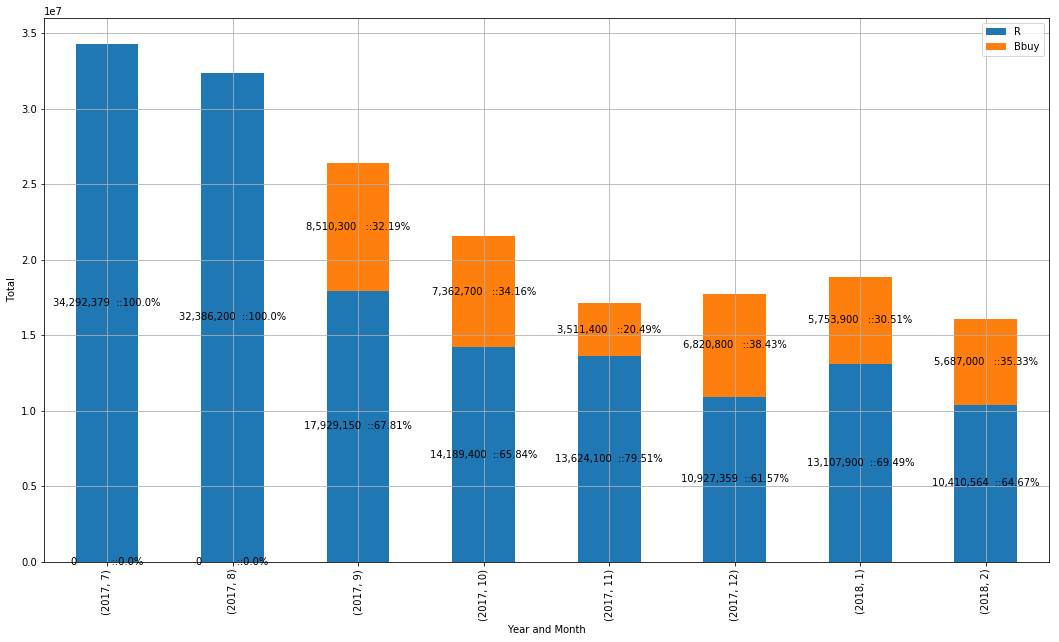

In [46]:

plt.figure()
DF_BMG = DF_Bmerge[['R', 'Bbuy']]
ax = DF_BMG.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_BMG.columns:
    pct_str=""
    for i in DF_BMG.index:
        value_str = "{:<12,}".format(int(DF_BMG.loc[i][j])) 
        
        if j == 'R':
            pct_str = "{0:.4}%".format(DF_Bmerge.loc[i]['prate'])
        elif j == 'Bbuy':
            pct_str = "{0:.4}%".format(DF_Bmerge.loc[i]['brate'])
       
        if pct_str != "":
            value_str = value_str + "::" + pct_str
#       label = DF_RCB[i][j] 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')


fig = ax.get_figure()
fig.savefig('Beer Sale:Buy Rate')
    

#  3. CJ Buy:Sell Rate

In [47]:

DF_CJmerge = pd.concat([DF_CJsales, DF_CJbuy], axis = 1) 

#DF_CJmerge.loc[DF_Bmerge['bbuy'].isnull(), 'bbuy'] = 0

DF_CJmerge['R'] = DF_CJmerge['CJsales'] - DF_CJmerge['CJbuy']
DF_CJmerge['brate'] = DF_CJmerge['CJbuy'] / DF_CJmerge['CJsales'] * 100
DF_CJmerge['prate'] = 100- (DF_CJmerge['CJbuy'] / DF_CJmerge['CJsales'] * 100)

DF_CJmerge




CJsales    CJbuy         R      brate      prate
year month                                                   
2017 7      16890571  8474601   8415970  50.173561  49.826439
     8      18277000  7594394  10682606  41.551644  58.448356
     9      13706500  6673702   7032798  48.690052  51.309948
     10     11784200  4974996   6809204  42.217512  57.782488
     11      9869750  4325622   5544128  43.827068  56.172932
     12     10456191  4400016   6056175  42.080486  57.919514
2018 1      12744000  2959125   9784875  23.219750  76.780250
     2       9275636  3821956   5453680  41.204247  58.795753

###  CJ Sell:Buy Graph

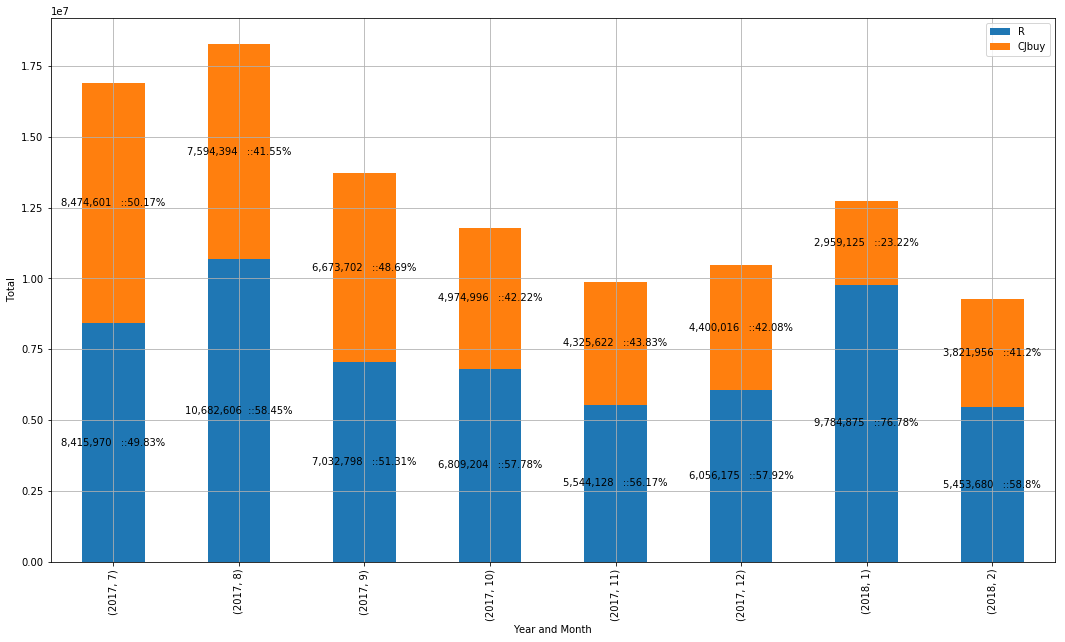

In [48]:

plt.figure()
DF_CJMG = DF_CJmerge[['R', 'CJbuy']]
ax = DF_CJMG.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_CJMG.columns:
    pct_str=""
    for i in DF_CJMG.index:
        value_str = "{:<12,}".format(int(DF_CJMG.loc[i][j])) 
        
        if j == 'R':
            pct_str = "{0:.4}%".format(DF_CJmerge.loc[i]['prate'])
        elif j == 'CJbuy':
            pct_str = "{0:.4}%".format(DF_CJmerge.loc[i]['brate'])
       
        if pct_str != "":
            value_str = value_str + "::" + pct_str
#       label = DF_RCB[i][j] 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')


fig = ax.get_figure()
fig.savefig('CJ Sell:Buy Rate')
    

# #########

# 99. Test Section

###  Old Query

In [ ]:
from itertools import cycle, islice
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

ind = np.arange(len(SR_Gtotal))
listtotal = SR_Gtotal.values
listindex = SR_Gtotal.index

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = listindex
y_pos = np.arange(len(listindex))
performance = listtotal
error = np.random.rand(len(listindex))

ax.barh(y_pos, performance, 0.6, align='center',
        color='green', ecolor='black')

for i, v in enumerate(listtotal):
    ax.text(v + 3, i + .25, "{:,}".format(v), color='green', fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(listindex)
ax.set_xticklabels([0,100,200,300,400,500,600,700,800,900,1000], rotation=90)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(u'Amount')
ax.set_title('Grand Total Amount Paid to CJ')

plt.show()

In [ ]:
SQL_Result_DF1


In [ ]:
# SQL_Result_DF_index3 = SQL_Result_DF1.set_index(['sku','pname', 'month'])

### GROUP BY 'SKU"

df_grouped = SQL_Result_DF1.groupby(['sku', 'pname'])

###

print 'Total Number of Groups', df_grouped.ngroups

"""
for k, g in df_grouped:
    print k[0], k[1],'\t\t', 
    gsum = g['gtotal'].sum()
    print 'Group Total', "{:>12,}".format(gsum), '원'
    print '-'*100
"""
    
df_grouped_sum =  SQL_Result_DF1.groupby([u'sku', u'pname']).sum()
print df_grouped_sum[df_grouped_sum['gtotal']>6000000]
print "2,000,000 ~ 6,000,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 2000000) & (df_grouped_sum['gtotal'] <= 6000000) ]
print "1,000,000 ~ 2,000,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 1000000) & (df_grouped_sum['gtotal'] <= 2000000) ]
#print ""
#print df_grouped_sum[(df_grouped_sum['gtotal'] > 600000) & (df_grouped_sum['gtotal'] <= 1000000) ]
print "400,000 ~ 1,000,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 400000) & (df_grouped_sum['gtotal'] <= 1000000) ]
print "200,000 ~ 400,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 200000) & (df_grouped_sum['gtotal'] <= 400000) ]
print "100,000 ~ 200,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 100000) & (df_grouped_sum['gtotal'] <= 200000) ]
print "50,000 ~ 100,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 50000) & (df_grouped_sum['gtotal'] <= 100000) ]
print "000,000 ~ 50,000"
print df_grouped_sum[(df_grouped_sum['gtotal'] > 0) & (df_grouped_sum['gtotal'] <= 50000) ]



# print df_grouped_sum[['gtotal','tqty']].sort_values('gtotal', ascending=False)




In [ ]:
SQL_Result_DF1.set_index(['sku', 'pname', 'month'])[:15].unstack(level=-1)

## Font in Plot 

In [ ]:
matplotlib.matplotlib_fname()

In [ ]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

In [ ]:
SQL_Result_DF1.set_index(['sku', 'pname', 'month'])[:15].unstack(level=-1).plot(kind='bar', stacked=False)
plt.rcParams["font.family"] = 'AppleMyungjo'
plt.rcParams['font.size'] = 8
plt.title(u'품목별 월별 매출현황' )
plt.show()

### Truncate unicode string with Unicode utf-8 

In [ ]:
print tuple[1]
def unicode_truncate(s, length, encoding='utf-8'):
    encoded = s.encode(encoding)[:length]
    return encoded.decode(encoding, 'ignore')
print unicode_truncate(tuple[1], 60)

### tuple insertion

In [ ]:
 t1 = ( (1, 'p100', 'JUL', 20), (1, 'p100', 'AUG', 30),
        (2, 'p200', 'JUL', 10), (2, 'p200', 'AUG', 40), (2, 'p200', 'SEP', 50),
        (3, 'p300', 'JUL', 40),
        (4, 'p400', 'JUL', 10), (4, 'p400', 'AUG', 20), (4, 'p400', 'SEP', 40), (4, 'p400', 'OCT', 60)
      )

In [ ]:
t1

### DataFrame from dictionary

In [ ]:
from pandas import Series, DataFrame
import numpy as np


dict1 = {'JUL':[10,20,30,40],
         'AUG':[11,21,31,41],
         'SEP':[12,22,32,42],
         'OCT':[13,23,33,43]
        }
df1 = DataFrame(dict1, columns=['JUL', 'AUG', 'SEP', 'OCT'], index=['p1','p2', 'p3','p4'])
df1

### new row insertion with dict form into DataFrame 

In [ ]:
df1.loc['p4'] = {'JUL':14, 'AUG':24, 'SEP':34, 'OCT':44}
df1

In [ ]:
df1.loc['p5'] = [50, 51, 52, 53]
df1

###  Test Unstack

In [ ]:
df1.unstack(level=0)

In [ ]:
index = pd.MultiIndex.from_tuples([('one', 'a'), ('one', 'b'),
                                   ('two', 'a'), ('two', 'b')])
s1 = Series(np.arange(1.0, 5.0), index=index)


In [ ]:
s1

In [ ]:
s.unstack(level=-1)

###  DataFrame with unstackI()

In [ ]:
dfmi = DataFrame(dict1, columns=['JUL', 'AUG', 'SEP', 'OCT'], index=index)
dfmi

In [ ]:
dfmi.unstack(level=-1)

In [ ]:
dfmi.unstack(level=0)

In [ ]:
dfmi.unstack(level=0).plot(kind='bar', stacked=True)

In [ ]:
dfmi.unstack(level=-2)

### Condition check of tuples and Make a dict from tuple elements

In [ ]:
t1

In [ ]:
colarray = ['JUL', 'AUG', 'SEP', 'OCT']

prev = None
new_d = {'JUL':None, 'AUG':None, 'SEP':None, 'OCT':None}
dfdic = DataFrame(None, columns=colarray)
for t in t1:    
    if prev != t[0] and prev != None:
        print new_d
        dfdic.loc[t[1]] = new_d
        new_d = {'JUL':None, 'AUG':None, 'SEP':None, 'OCT':None}
        
    new_d[t[2]]= t[3]
    prev = t[0]
print new_d

In [ ]:
dfdic

In [ ]:
df1.loc['p100'] = [None, None, None, None]
df1.loc['p100']['JUL'] = 299

df1


### SQL result to DataFrame in SQLite3

In [ ]:
myFrame = pd.read_sql_query(sql_cmd, conn)

In [ ]:
myFrame

In [ ]:
myFrame_T = myFrame.set_index(['sku','pname','month'])

In [ ]:
myFrame_T

In [ ]:
myFrame_T.loc[u'백설 바삭튀김가루(1Kg/EA) 미국-※미국산']

In [ ]:
myFrame_T[myFrame_T['sku'] == '100353']